# Patient Vital Signs Forecasting for Early Warning Systems

# Step 1: Define Your Project Goals
Objective: Predict a patient’s heart rate and systolic blood pressure for the next 6 hours using historical data.
Use Case: Early warning system to alert clinicians of potential patient deterioration.
Success Metric: Achieve a Mean Absolute Error (MAE) of less than 5% for both heart rate and blood pressure predictions.


# Step 2: Gather Your Data
Data Sources:

Dataset: MIT-BIH Arrhythmia Database

Link: MIT-BIH Arrhythmia Database
Why?

Free, no approval needed, and focuses on heart rate (ECG) data.
Great for practicing time-series forecasting.

Steps:

Go to the dataset page.
Click "Files" (top-right).
Download the files (e.g., 100.dat, 100.atr).
Use the wfdb Python library to load the data.

# Step 2: Set Up Your Environment

Install Python 3.8+ (if not already installed).
Install Required Libraries

In [1]:
import wfdb
import os

# Load record 100 (ECG signals)
record_path = os.path.join(os.getcwd(), "mitdb", "100")
record = wfdb.rdrecord(record_path)

# Load annotations (heartbeat locations)
annotation = wfdb.rdann(record_path, "atr")

# Print signal data and annotations
print("ECG Signals Shape:", record.p_signal.shape)
print("Annotations:", annotation.symbol[:10])


ECG Signals Shape: (650000, 2)
Annotations: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N']


# Step 3: Data Exploration
A. Load and Inspect the Data

In [4]:
import wfdb
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load record 100
record_path = os.path.join(os.getcwd(), "mitdb", "100")
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, "atr")

# Print basic information
print("Record information:", record.__dict__.keys())
print("Sampling frequency (Hz):", record.fs)
print("Signal length (samples):", record.sig_len)
print("Number of signals:", record.n_sig)
print("Annotations:", np.unique(annotation.symbol))


Record information: dict_keys(['record_name', 'n_sig', 'fs', 'counter_freq', 'base_counter', 'sig_len', 'base_time', 'base_date', 'comments', 'sig_name', 'p_signal', 'd_signal', 'e_p_signal', 'e_d_signal', 'file_name', 'fmt', 'samps_per_frame', 'skew', 'byte_offset', 'adc_gain', 'baseline', 'units', 'adc_res', 'adc_zero', 'init_value', 'checksum', 'block_size'])
Sampling frequency (Hz): 360
Signal length (samples): 650000
Number of signals: 2
Annotations: ['+' 'A' 'N' 'V']


B. Visualize the ECG Signal 

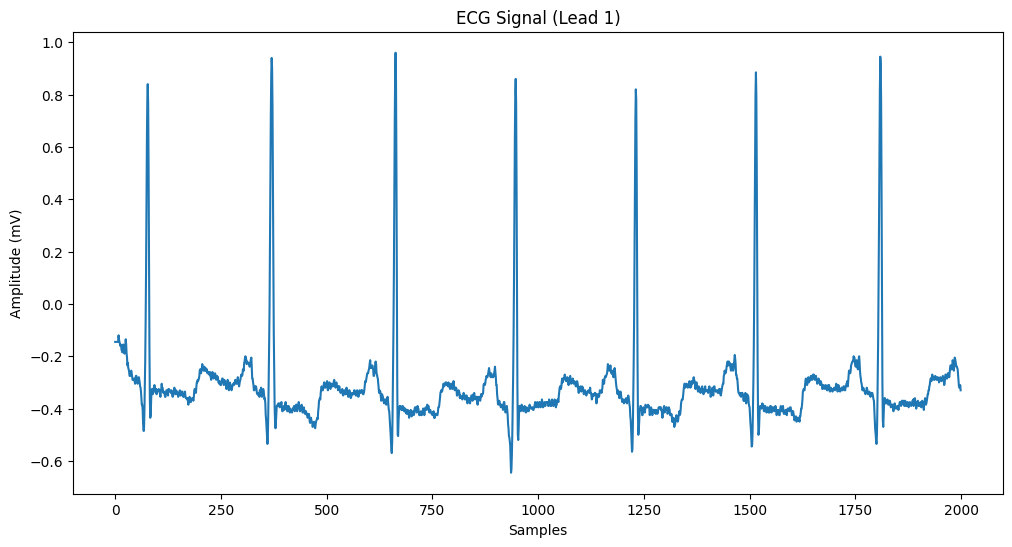

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(record.p_signal[:, 0][:2000])  # Plot first 2000 samples of lead 1
plt.title("ECG Signal (Lead 1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()


# Step 4: Preprocess the Data
A. Extract RR Intervals and Heart Rate

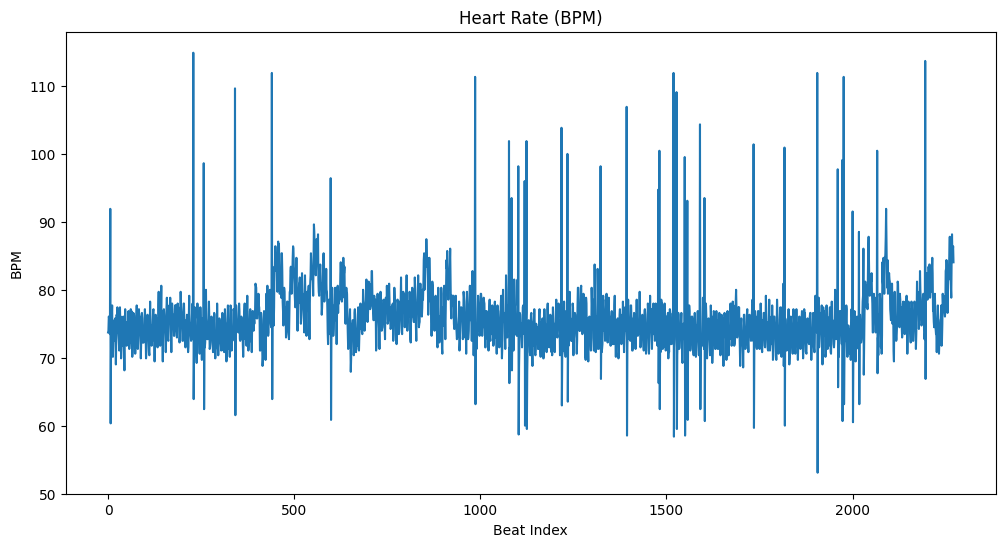

In [10]:
# Calculate RR intervals (in seconds)
rr_intervals = np.diff(annotation.sample) / record.fs

# Convert to heart rate (BPM)
heart_rate = 60 / rr_intervals

# Remove outliers (30 < HR < 200 BPM)
heart_rate = heart_rate[(heart_rate > 30) & (heart_rate < 200)]

# Plot heart rate
plt.figure(figsize=(12, 6))
plt.plot(heart_rate)
plt.title("Heart Rate (BPM)")
plt.xlabel("Beat Index")
plt.ylabel("BPM")
plt.show()


B. Smooth the Heart Rate
 

In [13]:
import pandas as pd
import numpy as np

# Convert heart_rate to a DataFrame with a column named 'heart_rate'
smoothed_hr = pd.DataFrame(heart_rate, columns=['heart_rate'])

# Smooth the heart rate using a rolling window
window_size = 5
smoothed_hr['smoothed_hr'] = smoothed_hr['heart_rate'].rolling(window=window_size, center=True).mean()

# Drop missing values
smoothed_hr = smoothed_hr.dropna()


C. Create Lag Features
 

In [16]:
# Create lag features using the 'smoothed_hr' column
for i in range(1, 6):
    smoothed_hr[f'lag_{i}'] = smoothed_hr['smoothed_hr'].shift(i)

# Drop missing values again after creating lag features
smoothed_hr = smoothed_hr.dropna()


# Step 5: Feature Engineering
A. Add Time-Based Features

In [19]:
# Calculate the indices to align annotation.sample with smoothed_hr
start_idx = window_size + 5  # accounting for rolling window and lag features
end_idx = start_idx + len(smoothed_hr)

# Extract the aligned time-based features
aligned_samples = annotation.sample[1:][start_idx:end_idx]

# Add hour and minute features
smoothed_hr["hour"] = (aligned_samples // (60 * 60 * record.fs)) % 24  # Hour of day
smoothed_hr["minute"] = (aligned_samples // (60 * record.fs)) % 60     # Minute of hour


B. Add Statistical Features
 

In [22]:
# Add rolling mean and standard deviation
smoothed_hr["rolling_mean"] = smoothed_hr['smoothed_hr'].rolling(window=10, center=True).mean()
smoothed_hr["rolling_std"] = smoothed_hr['smoothed_hr'].rolling(window=10, center=True).std()

# Drop missing values
smoothed_hr = smoothed_hr.dropna()


# Step 6: Split Data into Train/Test Sets
 

In [27]:
from sklearn.model_selection import train_test_split

# Features and target
X = smoothed_hr.drop(columns=['heart_rate', 'smoothed_hr']).values
y = smoothed_hr['smoothed_hr'].values

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# Step 6: Train XGBoost Model
 

In [32]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train the model
model = XGBRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} BPM")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 1.06 BPM
R² Score: 0.81


# Step 7: Visualize Predictions
 

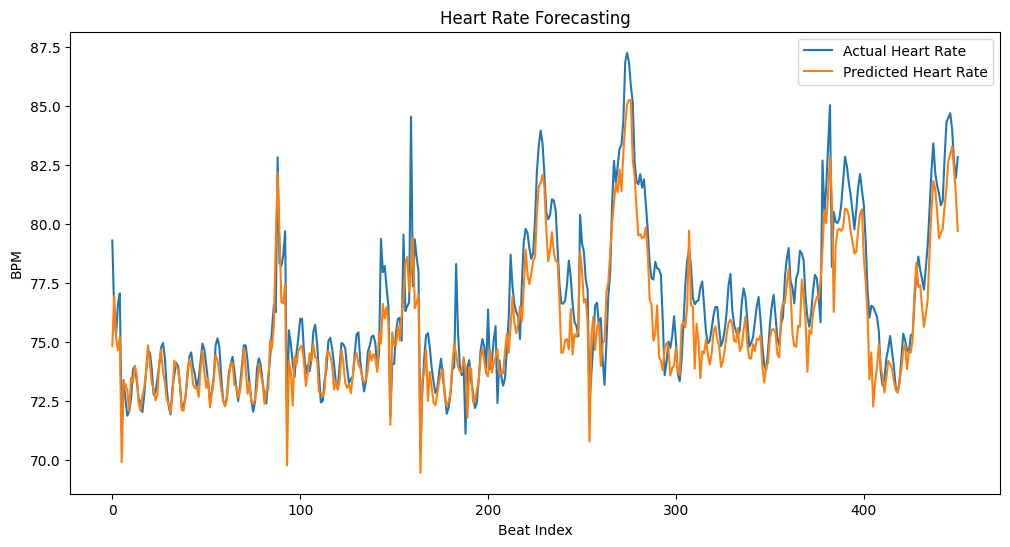

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Heart Rate")
plt.plot(y_pred, label="Predicted Heart Rate")
plt.title("Heart Rate Forecasting")
plt.xlabel("Beat Index")
plt.ylabel("BPM")
plt.legend()
plt.show()


# step 6: Train LSTM Model
 

In [38]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential([LSTM(50, input_shape=(1, X_train_scaled.shape[1])), Dense(1)])
model.compile(optimizer="adam", loss="mse")
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32)


C:\Users\Praava\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5694.1479
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5514.9824
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5145.4229
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4634.5005
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4095.9976
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3597.0312
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3155.6421
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2770.4478
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2434.7087
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2141.2949
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1883.9137
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1657.3185
Epoch 13/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1457.2069
Epoch 14/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1280.0488
Epoch 15/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4

# Step 7: Model Evaluation
A. Visualize Predictions

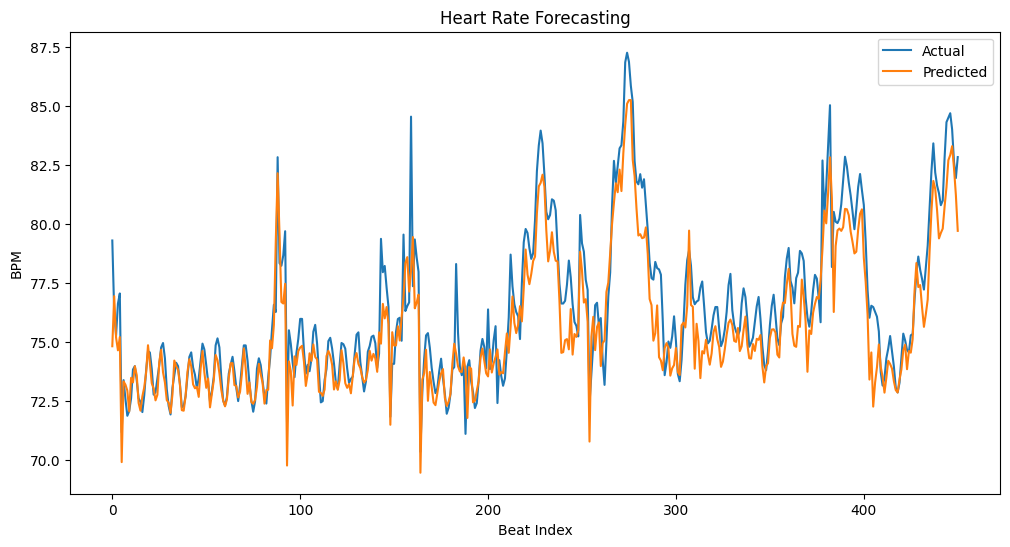

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Heart Rate Forecasting")
plt.xlabel("Beat Index")
plt.ylabel("BPM")
plt.legend()
plt.savefig("results/heart_rate_forecast.png")
plt.show()


B. Calculate Metrics
 

In [50]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")


R² Score: 0.81


# Step 8: Model Interpretation
A. Feature Importance

<Figure size 1000x600 with 0 Axes>

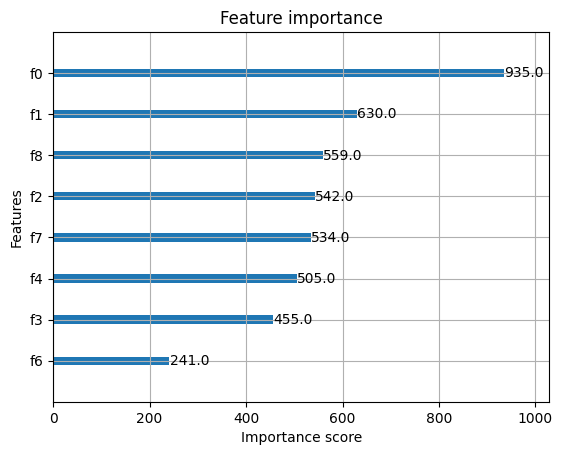

In [55]:
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import os

# Make sure the results folder exists
os.makedirs("results", exist_ok=True)

# Example: create and fit the model
model = XGBRegressor()
model.fit(X_train, y_train)  # <-- fit your model on training data

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.savefig("results/feature_importance.png")
plt.show()


B. SHAP Values
 

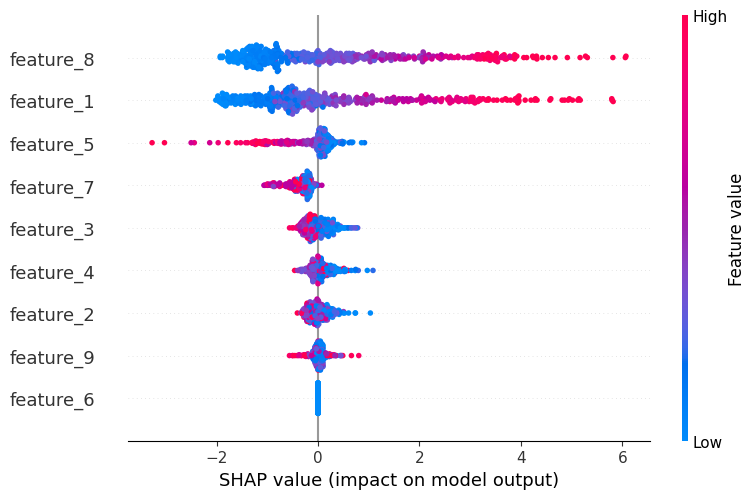

In [62]:
import pandas as pd
import shap
import os
import matplotlib.pyplot as plt

# Ensure results folder exists
os.makedirs("results", exist_ok=True)

# Convert X_test to DataFrame (use original feature names)
feature_names = [f'feature_{i+1}' for i in range(X.shape[1])]
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_df, feature_names=X_test_df.columns, show=False)
plt.savefig("results/shap_summary.png")
plt.show()


# Step 9: Deployment (Optional)
A. Save the Model
 

In [ ]:
import joblib

joblib.dump(model, "models/heart_rate_model.pkl")


B. Build a Flask API
 

In [ ]:
#from flask import Flask, request, jsonify

#app = Flask(__name__)
#model = joblib.load("models/heart_rate_model.pkl")

#@app.route("/predict", methods=["POST"])
#def predict():
    data = request.json
    prediction = model.predict([data["features"]])
    return jsonify({"prediction": float(prediction[0])})

#if __name__ == "__main__":
    app.run(debug=True)
